# Izgradite model klasifikacije: Ukusne azijske i indijske kuhinje


## Klasifikatori kuhinja 1

U ovoj lekciji istražit ćemo razne klasifikatore kako bismo *predvidjeli određenu nacionalnu kuhinju na temelju skupine sastojaka.* Pritom ćemo naučiti više o načinima na koje se algoritmi mogu koristiti za zadatke klasifikacije.

### [**Kviz prije predavanja**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Priprema**

Ova lekcija nadovezuje se na našu [prethodnu lekciju](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) gdje smo:

-   Napravili lagani uvod u klasifikacije koristeći skup podataka o svim sjajnim kuhinjama Azije i Indije 😋.

-   Istražili neke [dplyr glagole](https://dplyr.tidyverse.org/) za pripremu i čišćenje podataka.

-   Napravili prekrasne vizualizacije koristeći ggplot2.

-   Pokazali kako se nositi s neuravnoteženim podacima predobradom koristeći [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrirali kako `prep` i `bake` naš recept kako bismo potvrdili da će raditi kako treba.

#### **Preduvjet**

Za ovu lekciju trebat će nam sljedeći paketi za čišćenje, pripremu i vizualizaciju podataka:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) je [zbirka R paketa](https://www.tidyverse.org/packages) osmišljena kako bi znanost o podacima bila brža, lakša i zabavnija!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) okvir je [zbirka paketa](https://www.tidymodels.org/packages/) za modeliranje i strojno učenje.

-   `themis`: [themis paket](https://themis.tidymodels.org/) pruža dodatne korake za recepte za rad s neuravnoteženim podacima.

-   `nnet`: [nnet paket](https://cran.r-project.org/web/packages/nnet/nnet.pdf) pruža funkcije za procjenu feed-forward neuronskih mreža s jednim skrivenim slojem i za modele multinomijalne logističke regresije.

Možete ih instalirati na sljedeći način:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativno, skripta ispod provjerava imate li potrebne pakete za dovršetak ovog modula i instalira ih ako nedostaju.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Podijelite podatke na skupove za treniranje i testiranje.

Počet ćemo s nekoliko koraka iz naše prethodne lekcije.

### Uklonite najčešće sastojke koji stvaraju zabunu između različitih kuhinja, koristeći `dplyr::select()`.

Svi vole rižu, češnjak i đumbir!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Savršeno! Sada je vrijeme da podijelimo podatke tako da 70% podataka ide za treniranje, a 30% za testiranje. Također ćemo primijeniti tehniku `stratifikacije` prilikom dijeljenja podataka kako bismo `očuvali omjer svake kuhinje` u skupovima za treniranje i validaciju.

[rsample](https://rsample.tidymodels.org/), paket u Tidymodels, pruža infrastrukturu za učinkovito dijeljenje i ponovno uzorkovanje podataka:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Rješavanje neuravnoteženih podataka

Kao što ste možda primijetili u izvornom skupu podataka, kao i u našem skupu za treniranje, postoji prilično nejednaka raspodjela broja kuhinja. Korejske kuhinje su *gotovo* 3 puta brojnije od tajlandskih kuhinja. Neuravnoteženi podaci često negativno utječu na performanse modela. Mnogi modeli najbolje funkcioniraju kada je broj opažanja jednak i, stoga, imaju poteškoća s neuravnoteženim podacima.

Postoje dva glavna načina za rješavanje neuravnoteženih skupova podataka:

-   dodavanje opažanja manjinskoj klasi: `Over-sampling`, npr. korištenje SMOTE algoritma koji sintetički generira nove primjere manjinske klase koristeći najbliže susjede tih slučajeva.

-   uklanjanje opažanja iz većinske klase: `Under-sampling`

U našoj prethodnoj lekciji pokazali smo kako se nositi s neuravnoteženim skupovima podataka koristeći `recipe`. Recipe se može smatrati nacrtom koji opisuje koje korake treba primijeniti na skup podataka kako bi bio spreman za analizu podataka. U našem slučaju, želimo imati jednaku raspodjelu broja kuhinja u našem `skupu za treniranje`. Krenimo odmah.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Možete, naravno, potvrditi (koristeći pripremu + pečenje) da će recept funkcionirati kako očekujete - svi kulinarski označeni podaci imaju `559` opažanja.

Budući da ćemo koristiti ovaj recept kao predprocesor za modeliranje, `workflow()` će obaviti svu pripremu i pečenje za nas, tako da nećemo morati ručno procjenjivati recept.

Sada smo spremni za treniranje modela 👩‍💻👨‍💻!

## 3. Odabir vašeg klasifikatora

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Ilustracija: @allison_horst</figcaption>


Sada moramo odlučiti koji algoritam koristiti za zadatak 🤔.

U Tidymodels, [`parsnip package`](https://parsnip.tidymodels.org/index.html) pruža dosljedno sučelje za rad s modelima kroz različite pogonske sustave (pakete). Pogledajte dokumentaciju za parsnip kako biste istražili [vrste modela i pogonske sustave](https://www.tidymodels.org/find/parsnip/#models) te njihove odgovarajuće [argumente modela](https://www.tidymodels.org/find/parsnip/#model-args). Raznolikost može biti prilično zbunjujuća na prvi pogled. Na primjer, sljedeće metode uključuju tehnike klasifikacije:

-   C5.0 modeli klasifikacije temeljeni na pravilima

-   Fleksibilni diskriminantni modeli

-   Linearni diskriminantni modeli

-   Regularizirani diskriminantni modeli

-   Modeli logističke regresije

-   Modeli multinomijalne regresije

-   Modeli naivnog Bayesa

-   Strojevi za potporne vektore

-   Najbliži susjedi

-   Odlučujuća stabla

-   Metode ansambla

-   Neuronske mreže

Popis se nastavlja!

### **Koji klasifikator odabrati?**

Dakle, koji klasifikator biste trebali odabrati? Često je testiranje nekoliko njih i traženje dobrog rezultata način ispitivanja.

> AutoML rješava ovaj problem na jednostavan način pokretanjem ovih usporedbi u oblaku, omogućujući vam da odaberete najbolji algoritam za vaše podatke. Isprobajte ga [ovdje](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Također, izbor klasifikatora ovisi o našem problemu. Na primjer, kada se ishod može kategorizirati u `više od dvije klase`, kao u našem slučaju, morate koristiti `algoritam za višeklasnu klasifikaciju` umjesto `binarne klasifikacije.`

### **Bolji pristup**

Bolji način od nasumičnog pogađanja je slijediti ideje iz ovog preuzimljivog [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Ovdje otkrivamo da, za naš problem višeklasne klasifikacije, imamo nekoliko izbora:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Dio Microsoftove Cheat Sheet za algoritme, koji detaljno opisuje opcije za višeklasnu klasifikaciju</figcaption>


### **Razmišljanje**

Pogledajmo možemo li logički razmotriti različite pristupe s obzirom na ograničenja koja imamo:

-   **Duboke neuronske mreže su preteške**. S obzirom na naš čist, ali minimalan skup podataka, kao i činjenicu da obuku provodimo lokalno putem bilježnica, duboke neuronske mreže su previše zahtjevne za ovaj zadatak.

-   **Nema klasifikatora s dvije klase**. Ne koristimo klasifikator s dvije klase, što isključuje pristup jedan-protiv-svih.

-   **Stablo odluke ili logistička regresija mogli bi funkcionirati**. Stablo odluke moglo bi biti prikladno, ili multinomijalna regresija/višeklasna logistička regresija za podatke s više klasa.

-   **Višeklasna pojačana stabla odluke rješavaju drugačiji problem**. Višeklasno pojačano stablo odluke najprikladnije je za neparametarske zadatke, npr. zadatke dizajnirane za izradu rangiranja, pa nam nije korisno.

Također, obično je prije nego što se upustimo u složenije modele strojnog učenja, npr. metode ansambla, dobra ideja izgraditi najjednostavniji mogući model kako bismo dobili uvid u ono što se događa. Stoga ćemo za ovu lekciju započeti s modelom `multinomijalne regresije`.

> Logistička regresija je tehnika koja se koristi kada je izlazna varijabla kategorička (ili nominalna). Za binarnu logističku regresiju broj izlaznih varijabli je dvije, dok je za multinomijalnu logističku regresiju broj izlaznih varijabli veći od dvije. Pogledajte [Napredne metode regresije](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) za dodatno čitanje.

## 4. Obučavanje i evaluacija modela multinomijalne logističke regresije.

U Tidymodels-u, `parsnip::multinom_reg()`, definira model koji koristi linearne prediktore za predviđanje podataka s više klasa koristeći multinomijalnu distribuciju. Pogledajte `?multinom_reg()` za različite načine/engine koje možete koristiti za obuku ovog modela.

Za ovaj primjer, obučit ćemo model multinomijalne regresije putem zadane [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) engine.

> Vrijednost za `penalty` odabrao sam pomalo nasumično. Postoje bolji načini za odabir ove vrijednosti, na primjer, korištenjem `resamplinga` i `tuning` modela, o čemu ćemo kasnije raspravljati.
>
> Pogledajte [Tidymodels: Početak](https://www.tidymodels.org/start/tuning/) ako želite saznati više o podešavanju hiperparametara modela.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Odlično posao 🥳! Sada kada imamo recept i specifikaciju modela, trebamo pronaći način da ih spojimo u objekt koji će prvo obraditi podatke, zatim prilagoditi model na obrađenim podacima, a također omogućiti potencijalne aktivnosti post-obrade. U Tidymodels-u, ovaj praktični objekt zove se [`workflow`](https://workflows.tidymodels.org/) i praktično drži vaše komponente modeliranja! Ovo bismo nazvali *pipeline* u *Pythonu*.

Dakle, hajdemo sve spojiti u workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Radni tijekovi 👌👌! **`workflow()`** može se prilagoditi na sličan način kao i model. Dakle, vrijeme je za treniranje modela!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Izlaz prikazuje koeficijente koje je model naučio tijekom treniranja.

### Procjena treniranog modela

Vrijeme je da vidimo kako se model pokazao 📏 procjenjujući ga na testnom skupu! Započnimo s izradom predikcija na testnom skupu.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Odličan posao! U Tidymodels-u, procjena performansi modela može se provesti pomoću [yardstick](https://yardstick.tidymodels.org/) - paketa koji se koristi za mjerenje učinkovitosti modela pomoću metrika performansi. Kao što smo radili u našoj lekciji o logističkoj regresiji, započnimo izračunavanjem matrice konfuzije.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Kada se radi s više klasa, općenito je intuitivnije to vizualizirati kao toplinsku kartu, ovako:


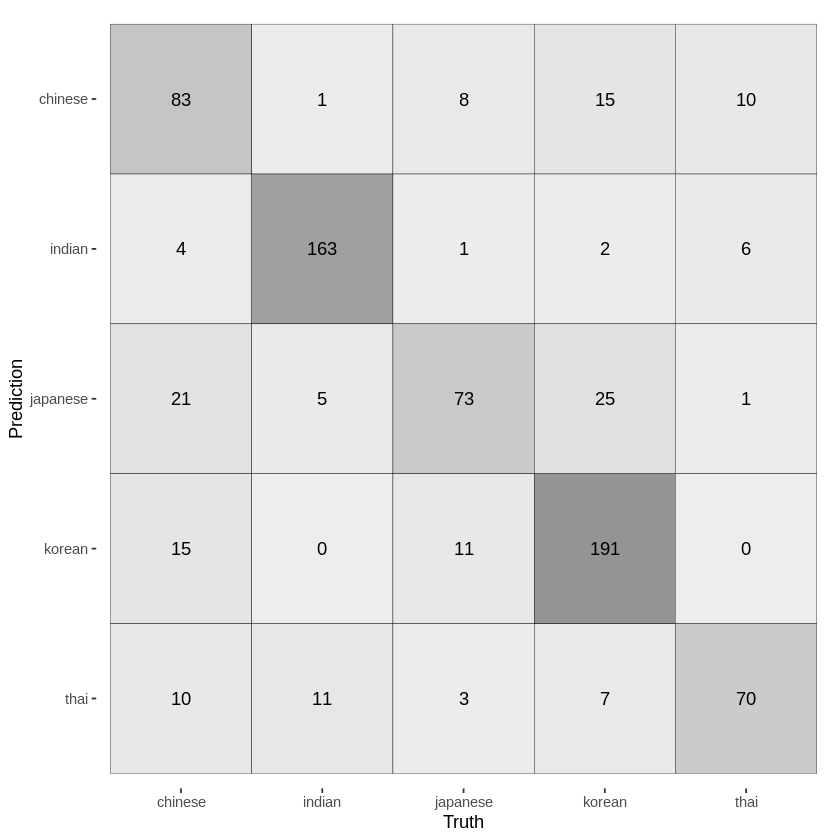

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Tamnije kvadratiće na grafu matrice zabune označavaju veći broj slučajeva, a nadamo se da možete vidjeti dijagonalnu liniju tamnijih kvadratića koja označava slučajeve gdje su predviđena i stvarna oznaka iste.

Sada ćemo izračunati sažetke statistike za matricu zabune.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Ako se usredotočimo na neke metrike poput točnosti, osjetljivosti, ppv-a, nismo loše krenuli za početak 🥳!

## 4. Dublje istraživanje

Postavimo jedno suptilno pitanje: Koji kriterij se koristi za odabir određenog tipa kuhinje kao predviđenog ishoda?

Pa, statistički algoritmi strojnog učenja, poput logističke regresije, temelje se na `vjerojatnosti`; dakle, ono što klasifikator zapravo predviđa je distribucija vjerojatnosti unutar skupa mogućih ishoda. Klasa s najvećom vjerojatnošću tada se bira kao najvjerojatniji ishod za dane opažanja.

Pogledajmo kako to funkcionira tako što ćemo napraviti i čvrste klasne predikcije i vjerojatnosti.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Možete li objasniti zašto je model prilično siguran da je prva opažanja tajlandska?

## **🚀Izazov**

U ovoj lekciji koristili ste svoje očišćene podatke za izradu modela strojnog učenja koji može predvidjeti nacionalnu kuhinju na temelju niza sastojaka. Odvojite malo vremena da proučite [mnoge opcije](https://www.tidymodels.org/find/parsnip/#models) koje Tidymodels nudi za klasifikaciju podataka i [druge načine](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) za primjenu multinomijalne regresije.

#### HVALA:

[`Allison Horst`](https://twitter.com/allison_horst/) za stvaranje nevjerojatnih ilustracija koje R čine pristupačnijim i zanimljivijim. Pronađite više ilustracija u njezinoj [galeriji](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) i [Jen Looper](https://www.twitter.com/jenlooper) za stvaranje originalne Python verzije ovog modula ♥️

<br>
Ubacio bih neke šale, ali ne razumijem igre riječi vezane uz hranu 😅.

<br>

Sretno u učenju,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Odricanje od odgovornosti**:  
Ovaj dokument je preveden korištenjem AI usluge za prevođenje [Co-op Translator](https://github.com/Azure/co-op-translator). Iako nastojimo osigurati točnost, imajte na umu da automatski prijevodi mogu sadržavati pogreške ili netočnosti. Izvorni dokument na izvornom jeziku treba smatrati mjerodavnim izvorom. Za ključne informacije preporučuje se profesionalni prijevod od strane stručnjaka. Ne preuzimamo odgovornost za bilo kakve nesporazume ili pogrešne interpretacije proizašle iz korištenja ovog prijevoda.
